In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install tweet-preprocessor

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPool1D, Bidirectional, Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
# Importing the dataset
df = pd.read_csv('/content/drive/MyDrive/TruthSeeker/Truth_Seeker_Model_Dataset.csv',header= 0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.head()

,Unnamed: 0,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer
0,0,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Mostly Agree,Agree
1,1,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,NO MAJORITY,Agree
2,2,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree
3,3,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Mostly Agree,Agree
4,4,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,Agree


In [ ]:
#make label column
def conversion(data):
  if (data['target'] == True and data['3_label_majority_answer'] == 'Agree') or (data['target'] == False and data['3_label_majority_answer'] == 'Disagree'):
    return 1
  else:
    return 0

In [ ]:
df['truthfullness']=df.apply(conversion,axis=1)

In [ ]:
labels=df['truthfullness'].values

In [ ]:
df.truthfullness.value_counts()

1    68985
0    65213
Name: truthfullness, dtype: int64

In [ ]:
from transformers import AutoTokenizer
from transformers import pipeline
import preprocessor


In [ ]:
# Function to preprocess tweet using tweet-preprocessor
def preprocess_tweet(tweet):
    cleaned_tweet = preprocessor.clean(tweet)
    return cleaned_tweet

In [ ]:
df['cleaned_tweet'] = df['tweet'].apply(preprocess_tweet)

In [ ]:
# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the tweets
tokenized_tweets = df['cleaned_tweet'].astype(str).apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [ ]:
# Tokenize all tweets and store the lengths
#token_lengths = [len(tokens) for tokens in tokenized_tweets]

# Calculate the maximum length
#max_length = max(token_lengths)

max_length = max(len(tokens) for tokens in tokenized_tweets)

In [ ]:
max_length

145

In [ ]:
X = pad_sequences(tokenized_tweets, maxlen=max_length, padding='post', truncating='post')

In [ ]:
X.shape

(134198, 145)

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token="OOV")
tokenizer.fit_on_texts(df['cleaned_tweet'].astype(str))
sequences = tokenizer.texts_to_sequences(df['cleaned_tweet'].astype(str))
X = pad_sequences(sequences, maxlen=145)  # Adjust the max length according to your data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(107358, 145)

In [ ]:
unique_values, counts = np.unique(to_categorical(np.array(y_test)), return_counts=True)
unique_values

array([0., 1.], dtype=float32)

In [ ]:
#Access the vocabulary
vocab = tokenizer.get_vocab()

# Convert the vocabulary to a word index dictionary
word_index = {word: idx for idx, word in enumerate(vocab)}

# Print the word index
print(word_index)

{'faltered': 0, 'shame': 1, 'mothers': 2, 'lissa': 3, 'chained': 4, 'owls': 5, '##ვ': 6, 'forum': 7, 'iaaf': 8, 'attraction': 9, 'explosives': 10, 'nicky': 11, '##mble': 12, 'hobart': 13, 'subjects': 14, 'funnel': 15, 'isil': 16, '##la': 17, 'lovely': 18, 'bodily': 19, 'b': 20, '##cut': 21, 'concert': 22, 'concurrently': 23, '##hawk': 24, 'superman': 25, 'conflicting': 26, 'mcqueen': 27, 'elliptic': 28, 'そ': 29, 'demanding': 30, 'correspondence': 31, '2004': 32, 'bae': 33, 'looming': 34, 'macro': 35, 'als': 36, 'peshawar': 37, '##routed': 38, 'ensemble': 39, '##udeau': 40, 'grams': 41, 'complimented': 42, 'excused': 43, 'newcastle': 44, '##hesive': 45, 'punjabi': 46, '##neuve': 47, 'dunbar': 48, 'traditionally': 49, 'severely': 50, 'cuba': 51, 'maintained': 52, 'boards': 53, '##v': 54, 'payne': 55, 'protected': 56, 'seed': 57, 'resident': 58, 'ª': 59, 'makeup': 60, 'lizard': 61, 'interception': 62, '1755': 63, 'act': 64, 'peter': 65, 'mal': 66, 'em': 67, '[unused612]': 68, '##cus': 69,

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Reshape, Attention, AdditiveAttention, Conv1D, MaxPooling1D

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def create_multihead_self_attention(d_model, num_heads):
  """
  Creates a multi-head self-attention layer with residual connection and layer normalization.

  Args:
      d_model: The dimension of the model's input and output.
      num_heads: The number of attention heads.

  Returns:
      A Keras functional layer.
  """
  # Define the query, key, and value projection layers.
  query_layer = layers.Dense(d_model, activation="relu")
  key_layer = layers.Dense(d_model, activation="relu")
  value_layer = layers.Dense(d_model, activation="relu")

  # Define the multi-head attention layer.
  def multihead_attention(inputs):
    queries, keys, values = inputs
    # Split the inputs into multiple heads.
    queries = layers.Lambda(lambda x: tf.reshape(x, (-1, num_heads, d_model // num_heads)))(queries)
    keys = layers.Lambda(lambda x: tf.reshape(x, (-1, num_heads, d_model // num_heads)))(keys)
    values = layers.Lambda(lambda x: tf.reshape(x, (-1, num_heads, d_model // num_heads)))(values)

    # Calculate the attention scores.
    attention_scores = layers.Dot(axes=[2, 3])([queries, keys])
    attention_scores /= tf.math.sqrt(tf.cast(d_model // num_heads, tf.float32))

    # Apply softmax to normalize the attention scores.
    attention_weights = layers.Softmax(axis=2)(attention_scores)

    # Context layer
    context_layer = layers.Dot(axes=[2, 1])([attention_weights, values])
    # Concatenate the heads back together.
    context_layer = layers.Lambda(lambda x: tf.reshape(x, (-1, d_model)))(context_layer)

    # Add a residual connection and apply layer normalization.
    output = layers.Add()([context_layer, inputs[0]])
    output = layers.LayerNormalization(epsilon=1e-6)(output)
    return output

  # Return the multi-head self-attention layer as a callable object.
  return keras.Model(inputs=[layers.Input(shape=d_model), layers.Input(shape=d_model), layers.Input(shape=d_model)], outputs=multihead_attention)

In [ ]:
def duplicate_values(inputs):
  queries, keys = inputs
  values = queries  # Duplicate the queries for values
  return queries, keys, values

In [ ]:
model = keras.Sequential([
  # Embedding layer for tweets (replace with your embedding logic)
  layers.Embedding(input_dim=len(word_index)+1, output_dim=128, input_length=max_length),
  # Your custom multi-head self-attention layer
  layers.MultiHeadAttention(num_heads=4, key_dim=128 // 4, dropout=0.1),
  # Additional layers as needed (e.g., feedforward, dropout, etc.)
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

TypeError: MultiHeadAttention.call() missing 1 required positional argument: 'value'

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
1678/1678 [==============================] - 1927s 1s/step - loss: 0.3127 - accuracy: 0.8794 - val_loss: 0.2204 - val_accuracy: 0.9345
Epoch 2/5
1678/1678 [==============================] - 1912s 1s/step - loss: 0.2079 - accuracy: 0.9418 - val_loss: 0.2199 - val_accuracy: 0.9355
Epoch 3/5
1678/1678 [==============================] - 1878s 1s/step - loss: 0.1899 - accuracy: 0.9480 - val_loss: 0.2226 - val_accuracy: 0.9342
Epoch 4/5
1678/1678 [==============================] - 1882s 1s/step - loss: 0.1720 - accuracy: 0.9536 - val_loss: 0.2443 - val_accuracy: 0.9251
Epoch 5/5
 299/1678 [====>.........................] - ETA: 23:37 - loss: 0.1507 - accuracy: 0.9601

In [ ]:
import tensorflow as tf

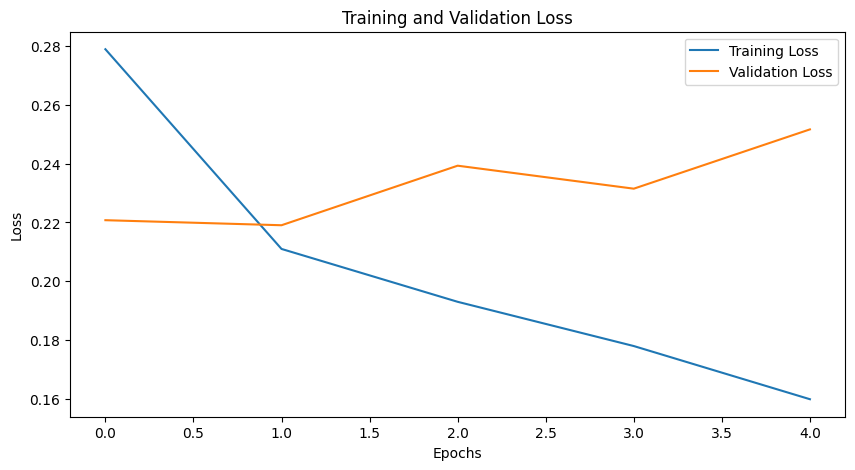

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

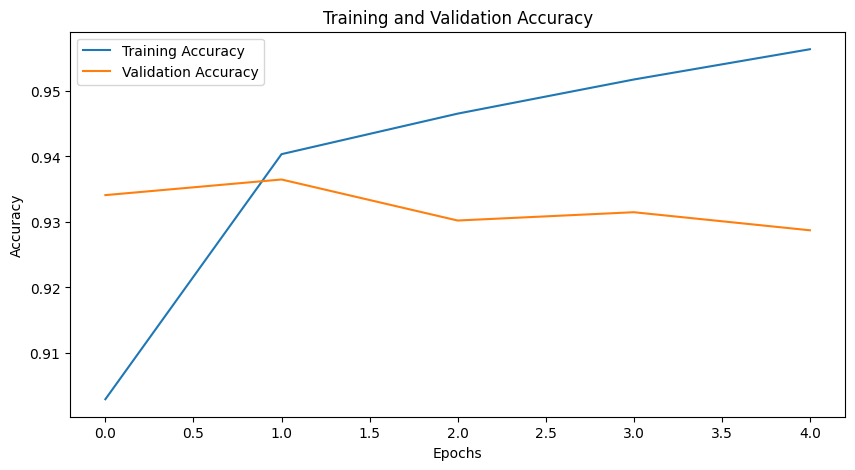

In [ ]:
# Plotting training and validation accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluating the model
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {val_accuracy}")


839/839 [==============================] - 187s 222ms/step - loss: 0.2517 - accuracy: 0.9287
Validation Accuracy: 0.9287257790565491


In [ ]:
# Making Predictions
predictions = model.predict(X_test)
predicted_labels = [np.argmax(pred) for pred in predictions]
classes=np.argmax(predictions)

839/839 [==============================] - 28s 33ms/step


In [ ]:
print("\nClassification Report:\n", classification_report(y_test, predictions.round()))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     13059
           1       0.92      0.94      0.93     13781

    accuracy                           0.93     26840
   macro avg       0.93      0.93      0.93     26840
weighted avg       0.93      0.93      0.93     26840



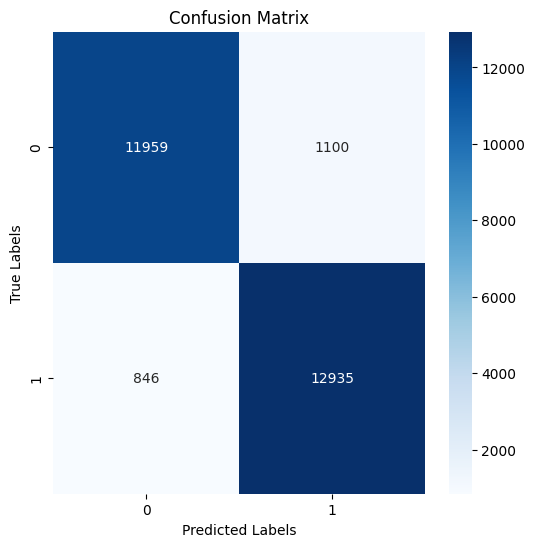

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions.round())
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
results = list(zip(df['tweet'][len(X_train):], predicted_labels))
for tweet, label in results[:10]:
    print(f"Tweet: {tweet[:50]}... Label: {label}")


In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Example sequences (a list of lists of integers)
sequences = [
    [1, 2, 3],
    [4, 5],
    [6, 7, 8, 9]
]

# Pad sequences to the same length (add zeros at the end)
padded_sequences = pad_sequences(sequences, maxlen=4, padding='post', truncating='post')

print(padded_sequences)


[[1 2 3 0]
 [4 5 0 0]
 [6 7 8 9]]
